Intro) Dans les jeux Pokemon, les pokémons sont regroupés dans ce que l'on appelle des "groupes d'oeufs". Ces groupes déterminent quels pokemons peuvent se reproduire entre eux et sont par conséquent similaire à la notion de "genre animal". Par exemple, le lion et le tigre font parti du même genre et peuve ainsi donner naissance à des hybrides.

Le but de ce projet est d'essayer de construire un modèle de prediction de l'appartenance ou non d'un pokémon aux différents groupes d'oeufs (CLASSIFICATION MULTILABEL)

Dans ce notebook, on analyse les clusters définis dans le notebook 3- SBD CLUSTERING.Rmd. et on construit les centroides via l'algorithme KSHAPE :https://github.com/TheDatumOrg/kshape-python/blob/main/README.md
Les clusters ont été construits via l'algorithme PAM, sur la base de la mesure de distance SBD (SHAPE BASED DISTANCE) : https://rdrr.io/cran/dtwclust/man/SBD.html

Une fois cette étape réalisée, on va extraire des features des séries temporelles via le package tsfresh. Ces features serviront en tant que variables prédictives pour le modèle final.

In [15]:
#Import ds librairies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import os
import scipy 
import warnings
from kshape.core import kshape as ks_cpu
from kshape.core import zscore #Utiliser pour extraire les centroides des classes
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
import shutil
from tqdm import tqdm
warnings.filterwarnings('ignore')

1) Déplacer les fichiers dans des dossiers en fonction du cluster d'appartenance

In [27]:
#Deplacer les csv, plots et spectrogrammes dans les dossiers des différents clusters SBD
clusters = pd.read_csv("classes.csv")
for i in tqdm(range(1,19)) :
    elements_clusters = clusters.loc[clusters['clusters'] == i]
    elements_clusters = list(elements_clusters["csv_files"])
    for element in elements_clusters :
        #CSV
        source_csv = f"./CSV/{element}"
        destination_csv = f"./CLASSES/{i}/CSV/{element}"
        shutil.move(source_csv, destination_csv, copy_function = shutil.copytree)
        
        #audio plot
        element = element.replace(".csv",".png")
        source_plot = f"./PLOTS/{element}"
        destination_plot = f"./CLASSES/{i}/PLOTS/{element}"
        shutil.move(source_plot, destination_plot, copy_function = shutil.copytree)
        
        #spectro plot
        source_plot = f"./SPECTROS/{element}"
        destination_plot = f"./CLASSES/{i}/SPECTROS/{element}"
        shutil.move(source_plot, destination_plot, copy_function = shutil.copytree)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 10.10it/s]


2) Lire les données des séries temporelles

In [3]:
#Lire les différentes series temporelles par cluster
num_clusters = os.listdir("./CLASSES")
All_clusters = {}
for numero_cluster in tqdm(num_clusters) :
    series_temporelles_cluster = []
    cluster_csv_folder = os.listdir(f"./CLASSES/{numero_cluster}/CSV")
    for csv in cluster_csv_folder:
        time_serie = pd.read_csv(f"./CLASSES/{numero_cluster}/CSV/{csv}")["amplitude"]
        series_temporelles_cluster.append(time_serie)
    All_clusters[int(numero_cluster)] = series_temporelles_cluster

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.99it/s]


3) Analyse générale

On va regarder les variables telles que la longueur maxim des signaux d'un cluster, la valeur moyenne des signaux...

In [34]:
#Calculer différents éléments d'analyse générale sur les clusters
j=0
max_length = 0
SIG = [None]*18
class_card = [None]*18
MEAN = [None]*18
STD = [None]*18
EN = [None]*18

for key,signal in All_clusters.items(): 
    class_len = []
    class_var = []
    class_mean = []
    class_mean_en = []
    for sig in signal :
        class_len.append(len(sig))
        class_var.append(np.std(np.array(sig)))
        class_mean.append(np.mean(np.array(sig)))
        class_mean_en.append(np.sum(np.square(np.array(sig)))/len(sig))
    SIG[key-1]=class_len
    STD[key-1]=class_var
    MEAN[key-1]=class_mean
    EN[key-1] = class_mean_en
    class_card[key-1]=len(class_len)

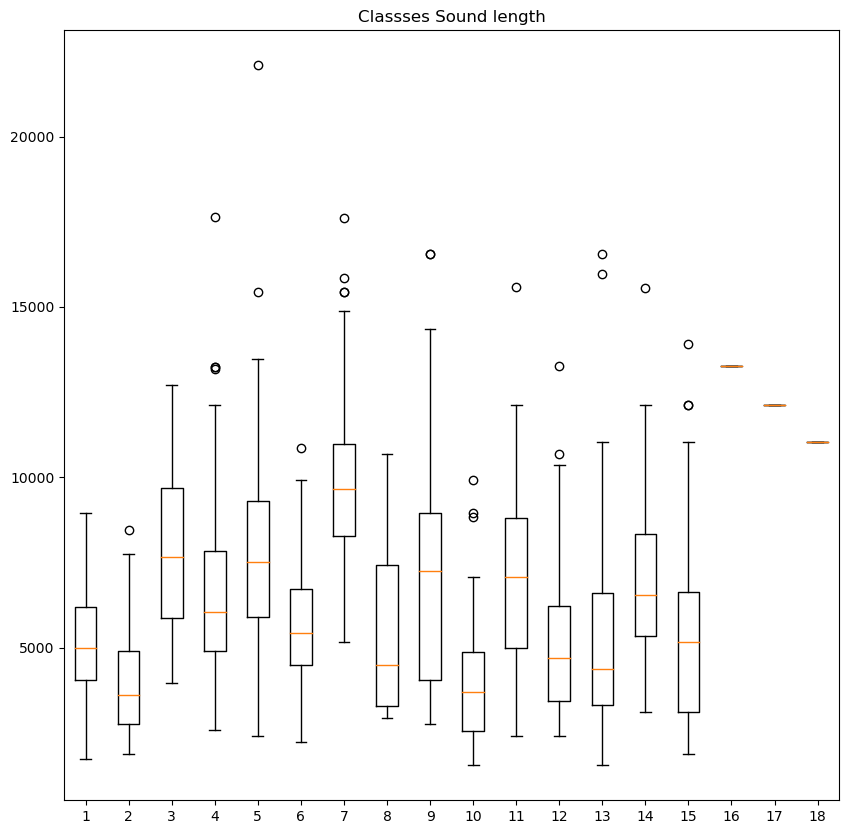

In [36]:
#Longuer des signaux dans les différents clusters
plt.figure(figsize=(10,10))
plt.boxplot(SIG)
plt.title("Classses Sound length")
plt.show()

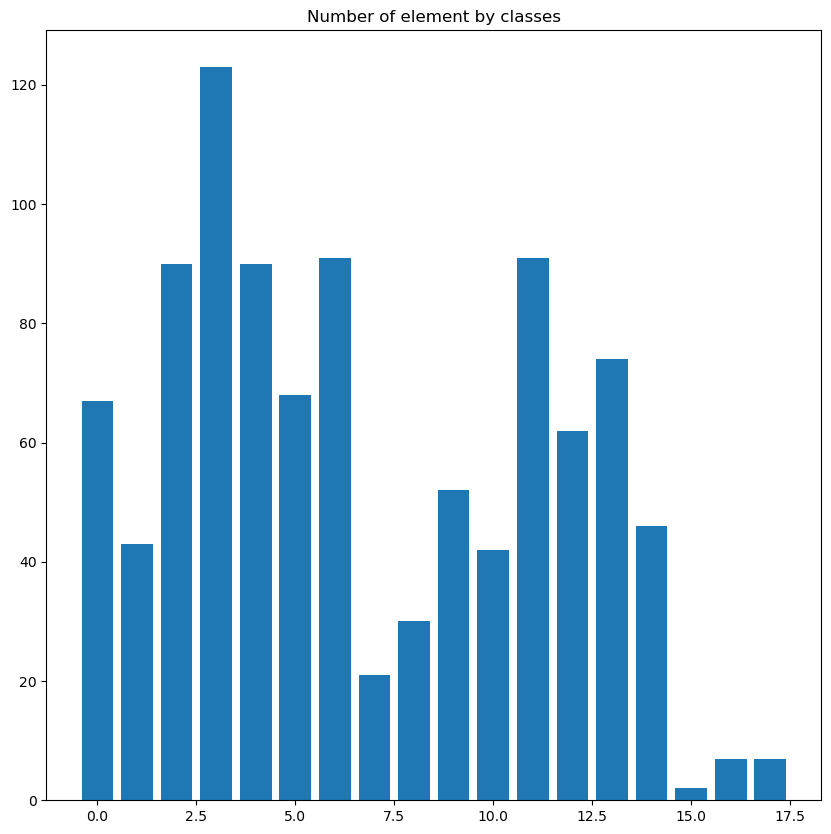

In [37]:
#Nombre de signaux dans chaque cluster
plt.figure(figsize=(10,10))
plt.bar(x =np.arange(18),height=class_card)
plt.title("Number of element by classes")
plt.show()

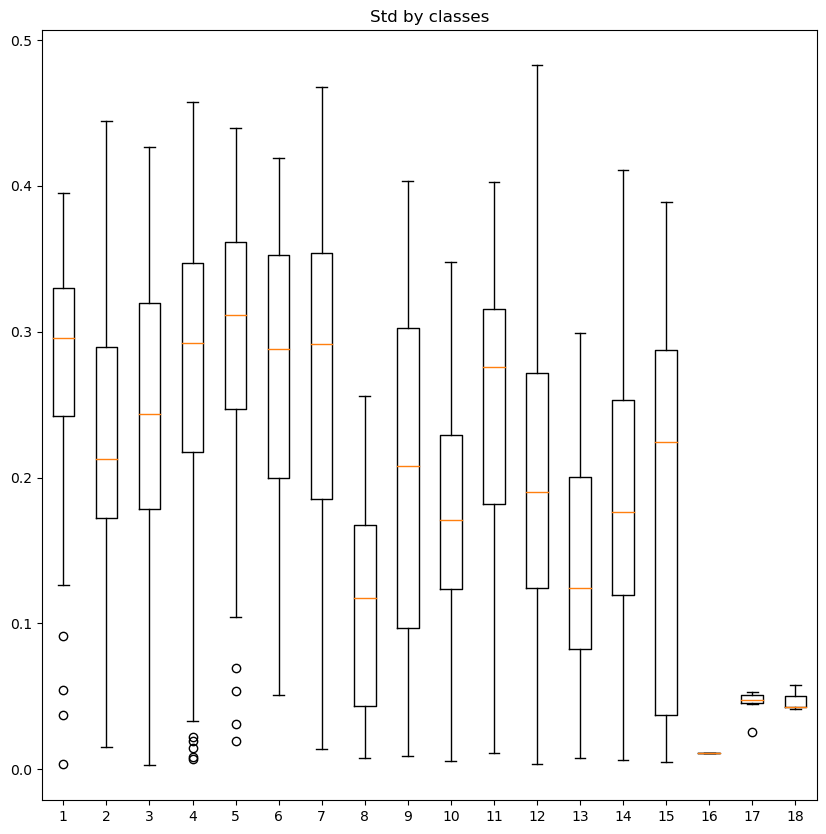

In [39]:
#Ecart type de l'amplitude des signaux par classe
#Sachant que la moyenne tourne forcément autour de 0 car signal audio
plt.figure(figsize=(10,10))
plt.boxplot(STD)
plt.title("Std by classes")
plt.show()

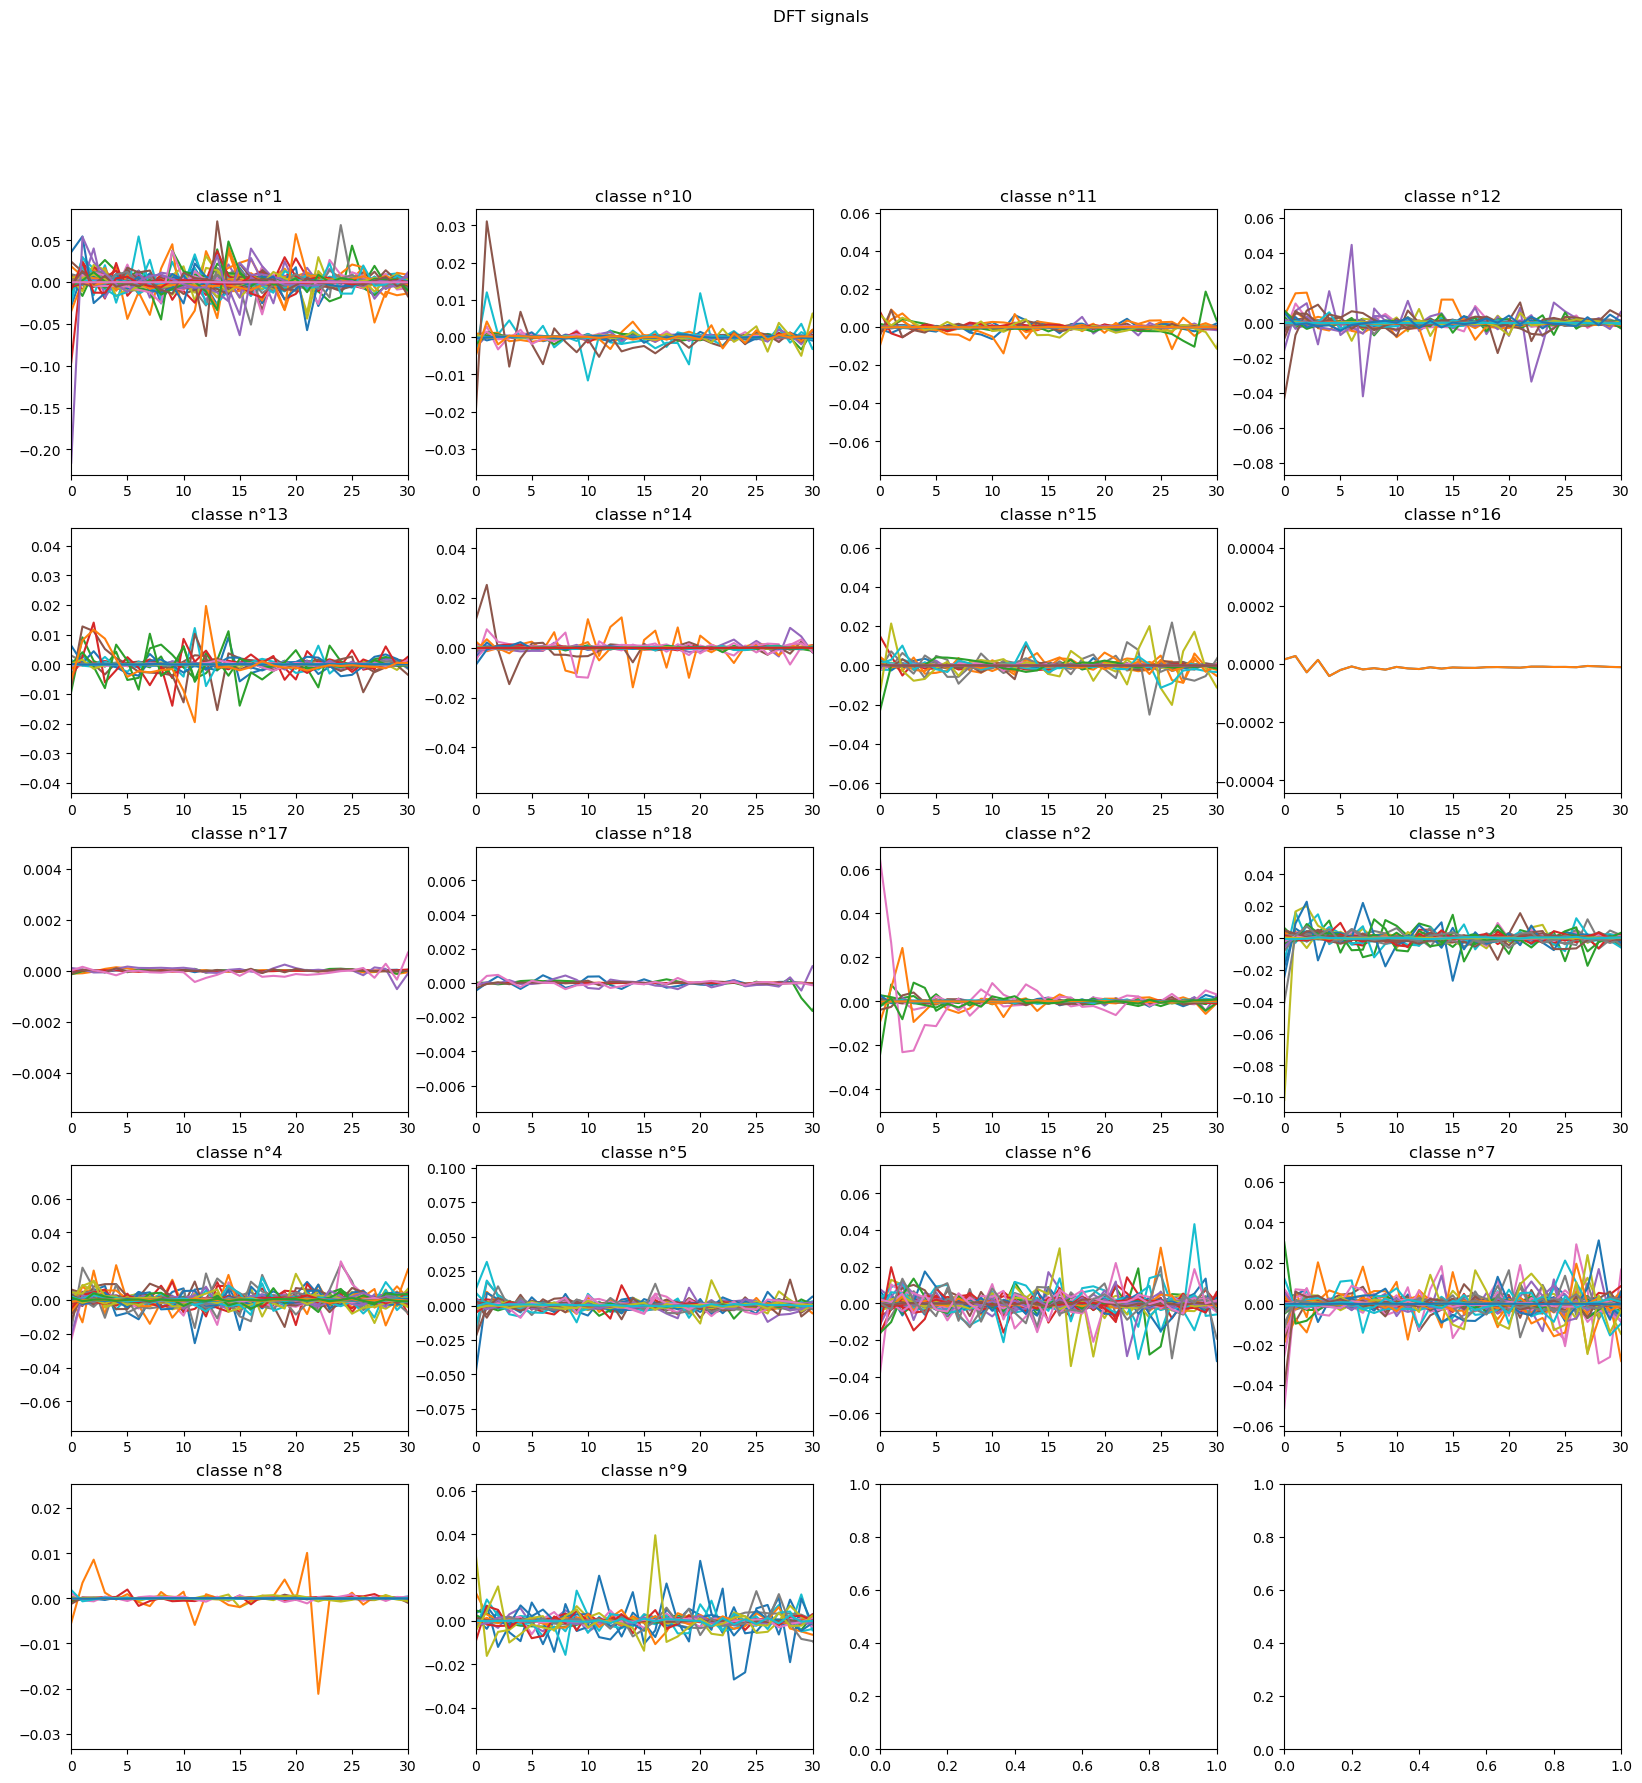

In [41]:
#Visualisation de signaux de Transformation de Fourier discretes
fig , axs = plt.subplots(5,4,figsize=(20,20))
j=0
for key,signal in All_clusters.items(): 
    for sig in signal :
        axs[j//4,j%4].plot(np.fft.fft(sig)/len(sig))
    axs[j//4,j%4].title.set_text("classe n°"+str(key))
    axs[j//4,j%4].axis(xmin=0,xmax=30)
    j+=1
fig.suptitle("DFT signals")
plt.show()

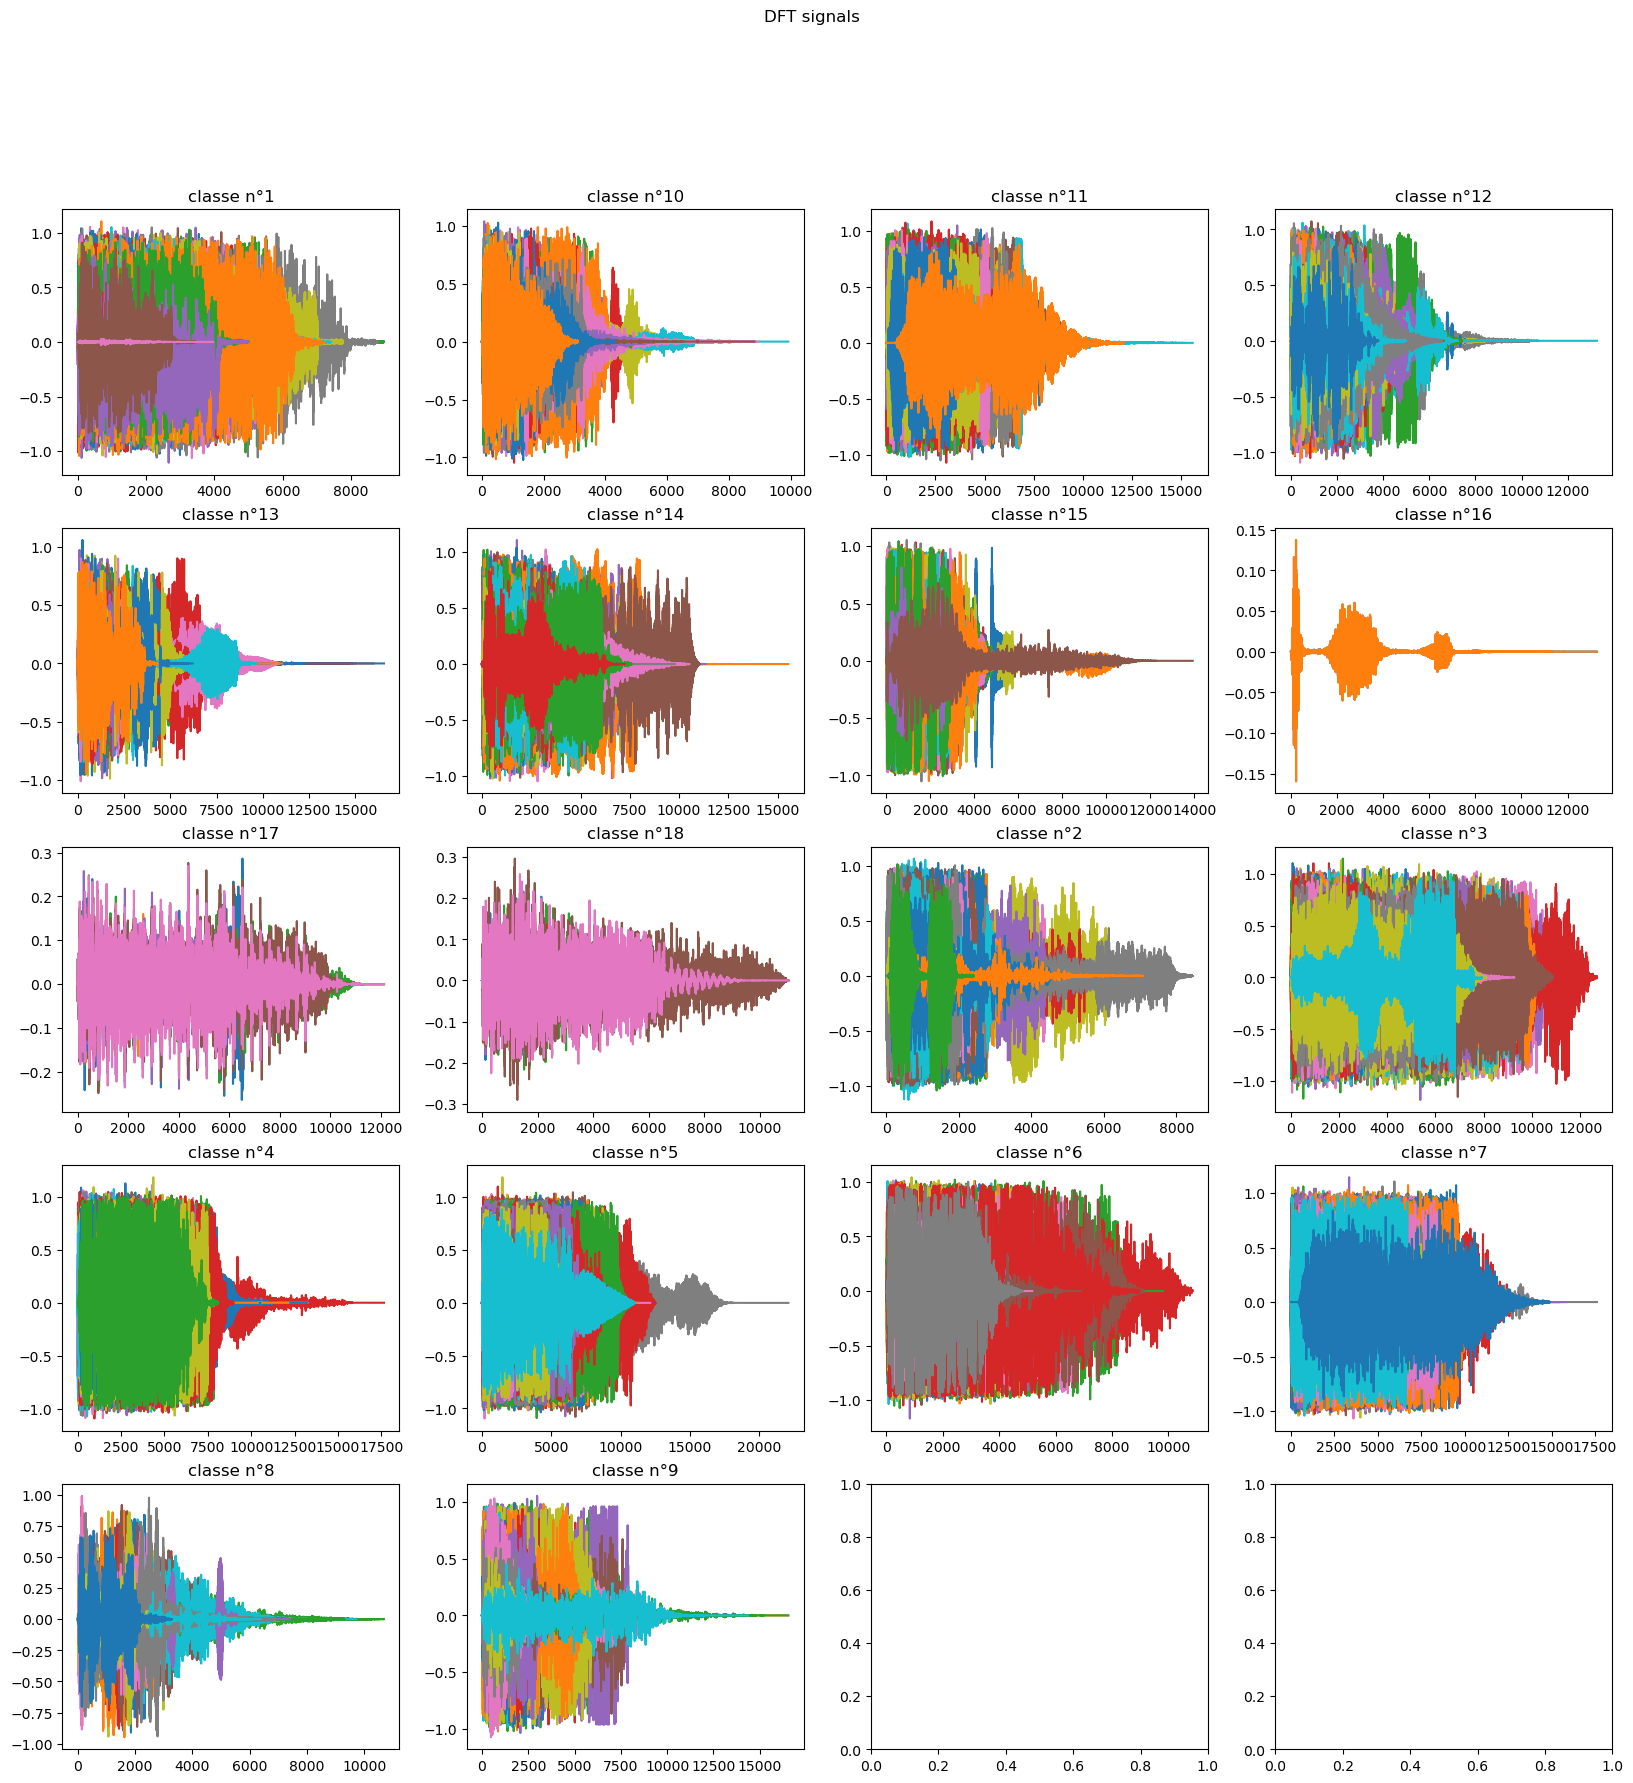

In [42]:
fig , axs = plt.subplots(5,4,figsize=(20,20))
j=0
for key,signal in All_clusters.items(): 
    for sig in signal :
        axs[j//4,j%4].plot(sig)
    axs[j//4,j%4].title.set_text("classe n°"+str(key))
    j+=1
fig.suptitle("DFT signals")
plt.show()

4) Extraction des centroides des clusters via l'algorithme KSHAPE

On remarque que le centroide de la classe 16 correspond parfaitement aux séries constituant le cluster. En effet, cette classe est constitué de 2 pokemons qui ont exactement le même cri :
- Dofin https://www.pokepedia.fr/Dofin
- Superdofin qui est l'évolution de Dofin https://www.pokepedia.fr/Superdofin

100%|███████████████████████████████████████████████████████████████████████████████| 18/18 [1:21:57<00:00, 273.21s/it]


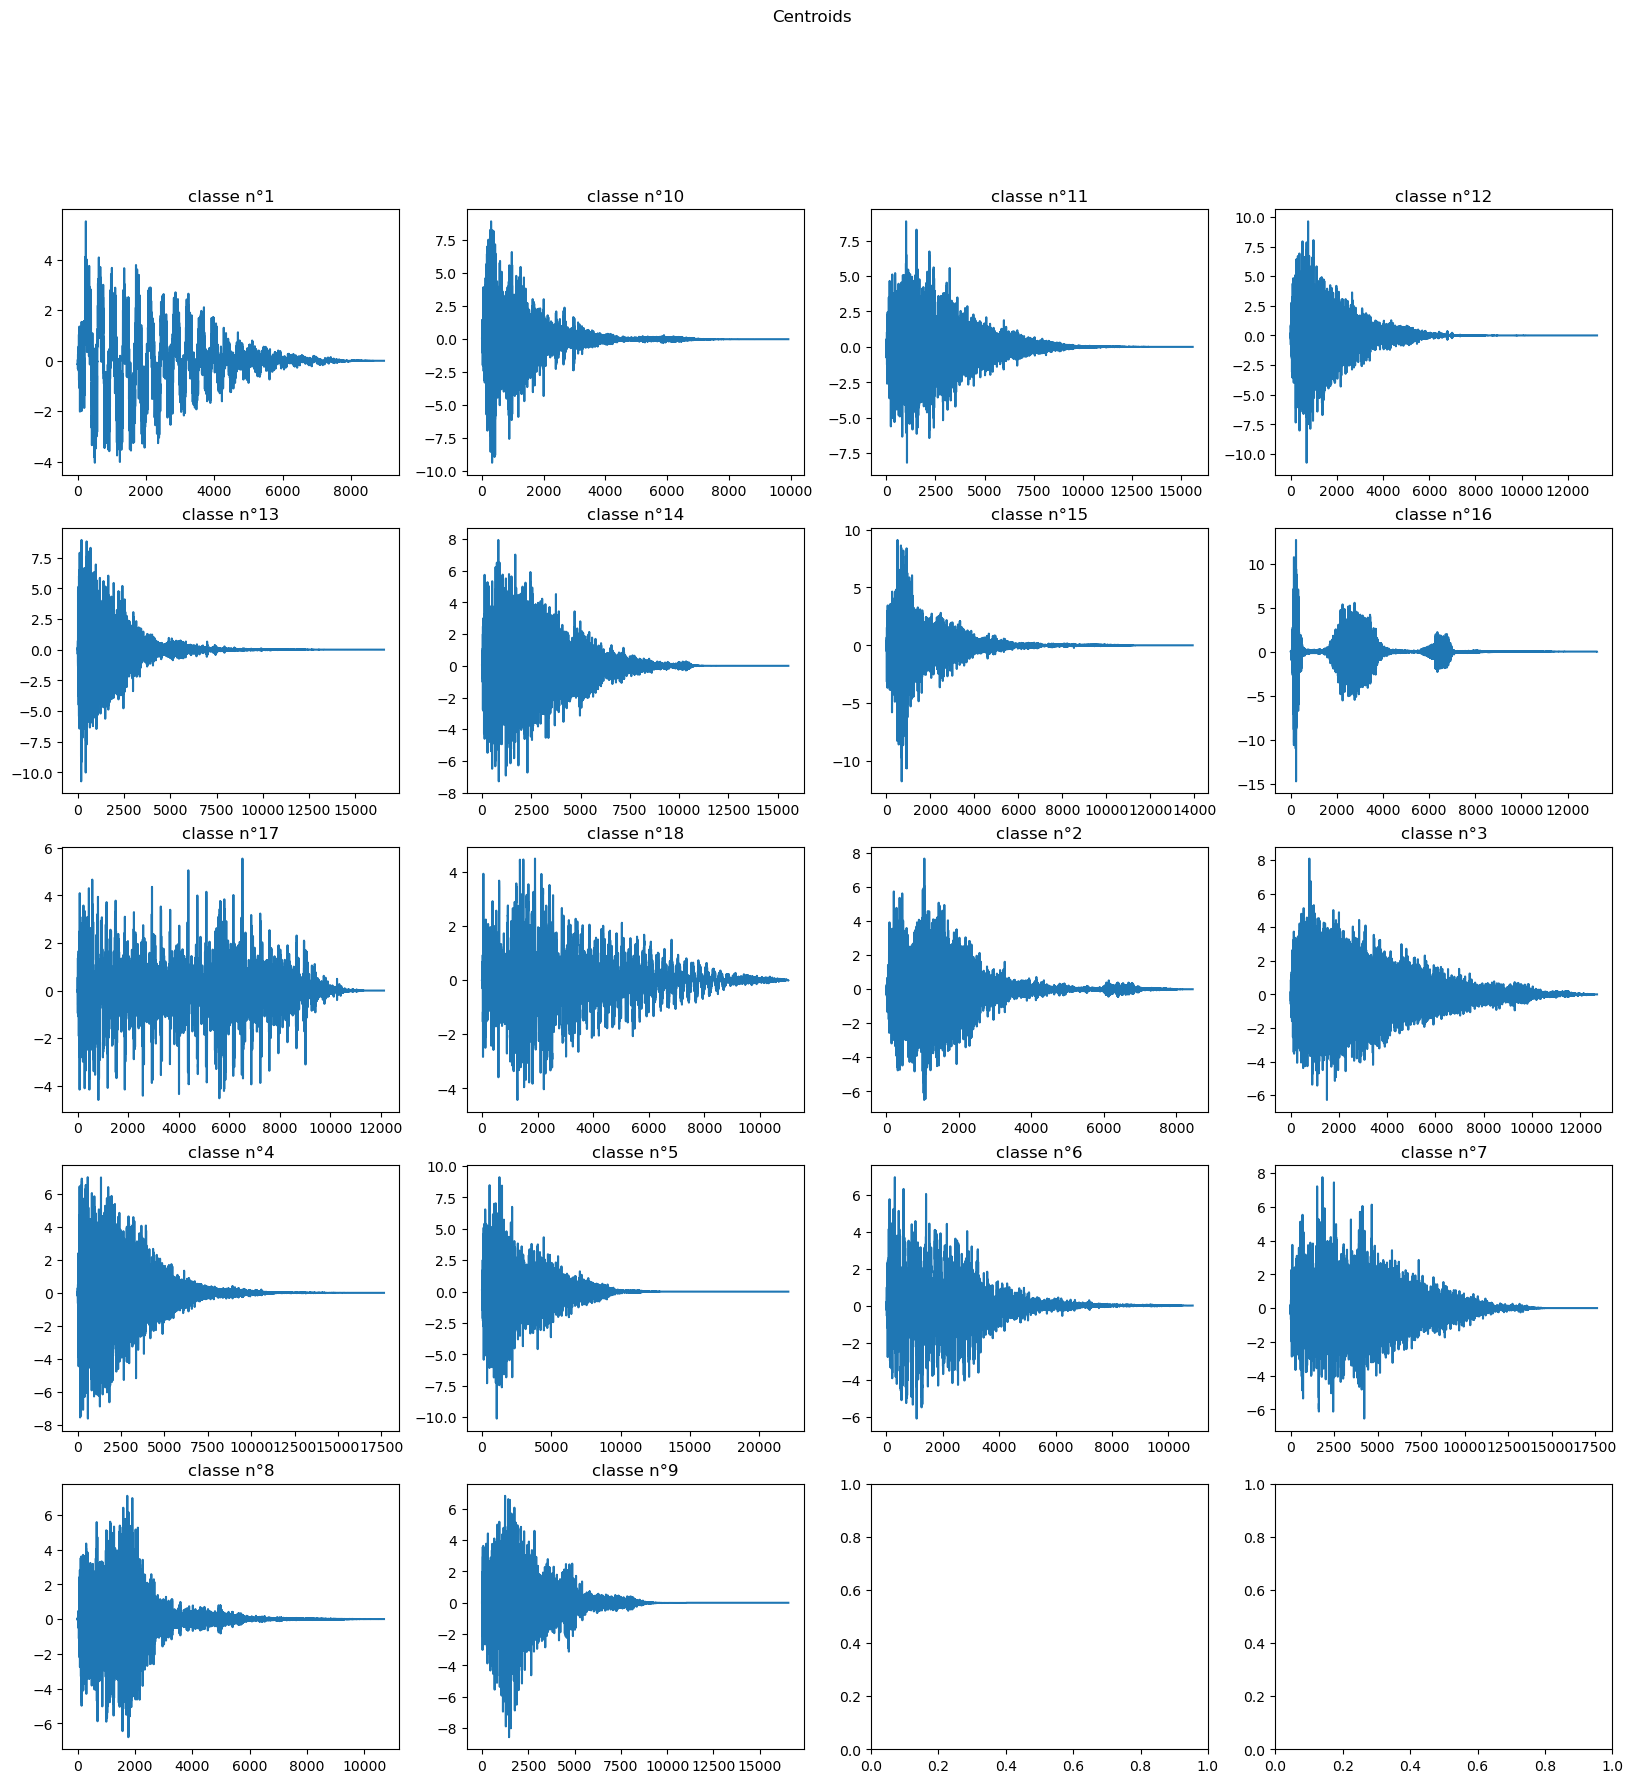

In [16]:
#Extraire les centroides des classes grace à l'algorithme KSHAPE
fig , axs = plt.subplots(5,4,figsize=(20,20))
j=0
Centroids = {}
for key,signal in tqdm(All_clusters.items()): 
    time_series = []
    length_max = 0
    for sig in signal :
        if length_max < sig.size :
            length_max = sig.size
    for sig in signal :
        mean = sig.mean()
        sig = list(sig)
        for i in range(length_max-len(sig)) :
            sig.append(mean)
        time_series.append(np.array(sig))
    #Preprocessing pour l'algo KSHAPE
    time_series = np.array(time_series)
    time_series = np.expand_dims(time_series, axis=2)
    cluster_num = 1
    clusters = ks_cpu(zscore(time_series, axis=1), cluster_num)
    centroid = clusters[0][0]
    Centroids[key] = centroid
    axs[j//4,j%4].plot(centroid)
    axs[j//4,j%4].title.set_text("classe n°"+str(key))
    j+=1
fig.suptitle("Centroids")
plt.show()

In [25]:
#SAUVEGARDER LES RESULTATS DES CENTROIDS
for key,centroid in tqdm(Centroids.items()): 
    times = np.arange(len(centroid))
    centroid = [elem[0] for elem in centroid]
    dic = {"sample_unit":list(times),"amplitude":centroid}
    df = pd.DataFrame.from_dict(dic)
    df.to_csv(f"./CENTROIDS/{key}.csv",index = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 38.69it/s]


5) Analyse des composantes de Trend, residualité, autocorrélation et spectrogramme des centroides

In [26]:
#Analyse de la trend, residuel, saisonalité des centroides des séries
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

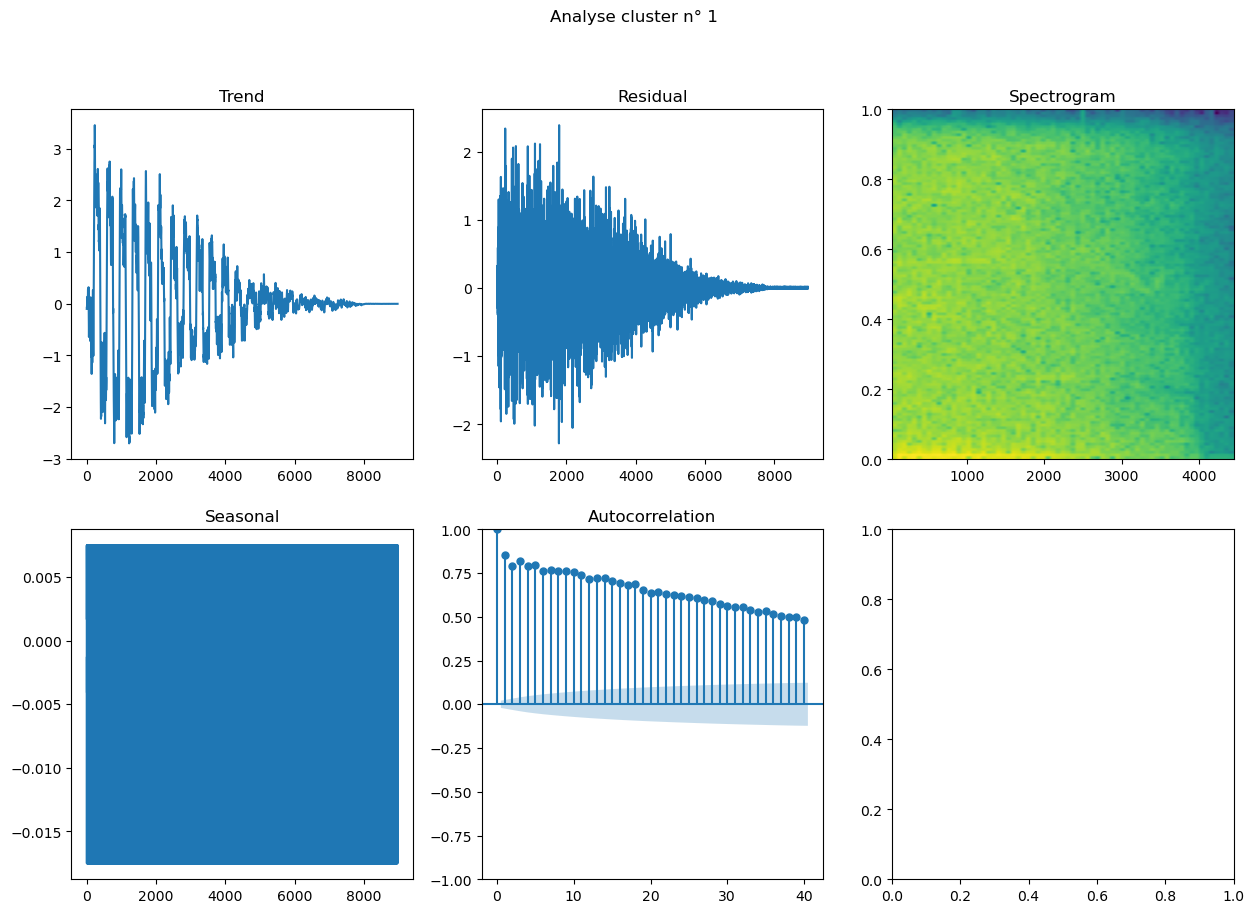

  6%|████▌                                                                              | 1/18 [00:00<00:10,  1.57it/s]

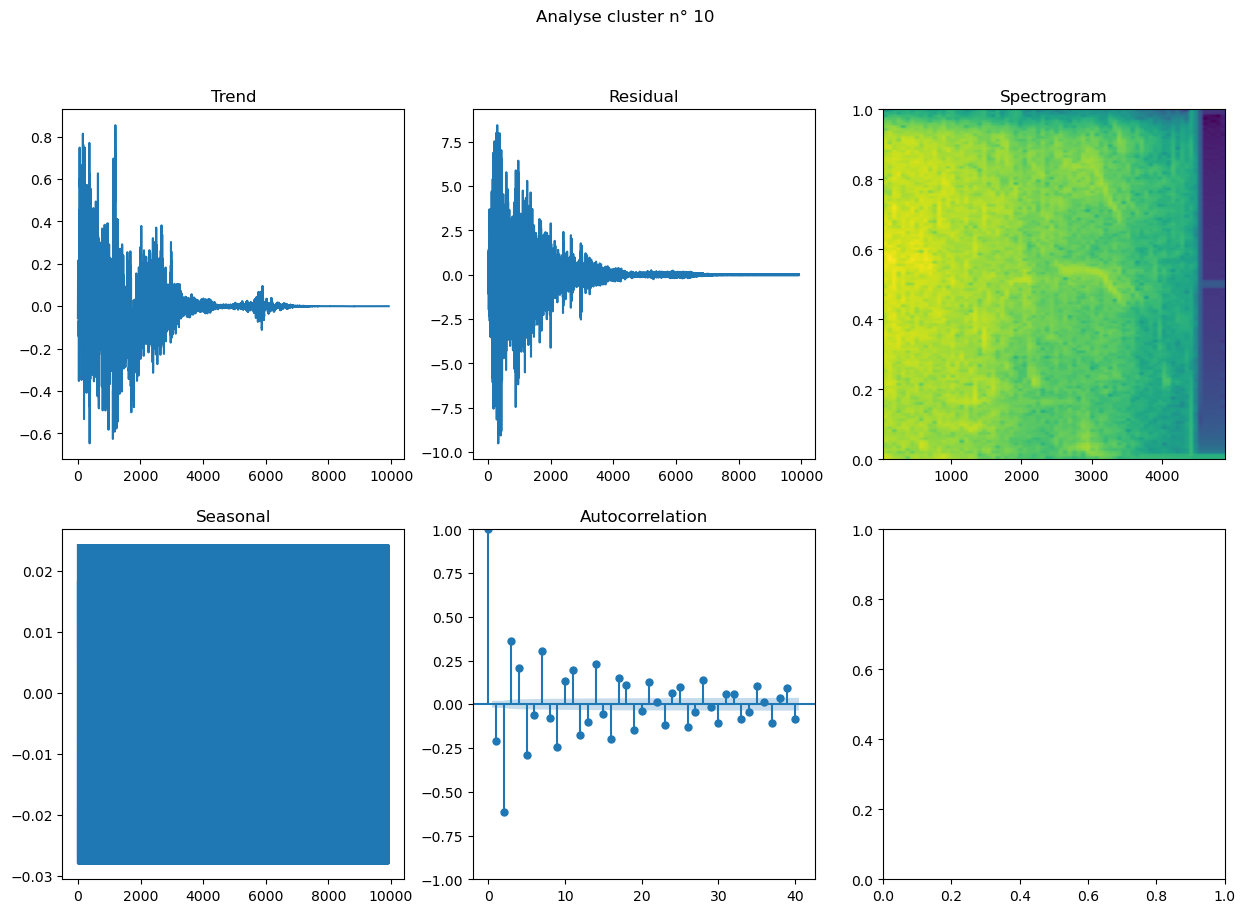

 11%|█████████▏                                                                         | 2/18 [00:01<00:09,  1.62it/s]

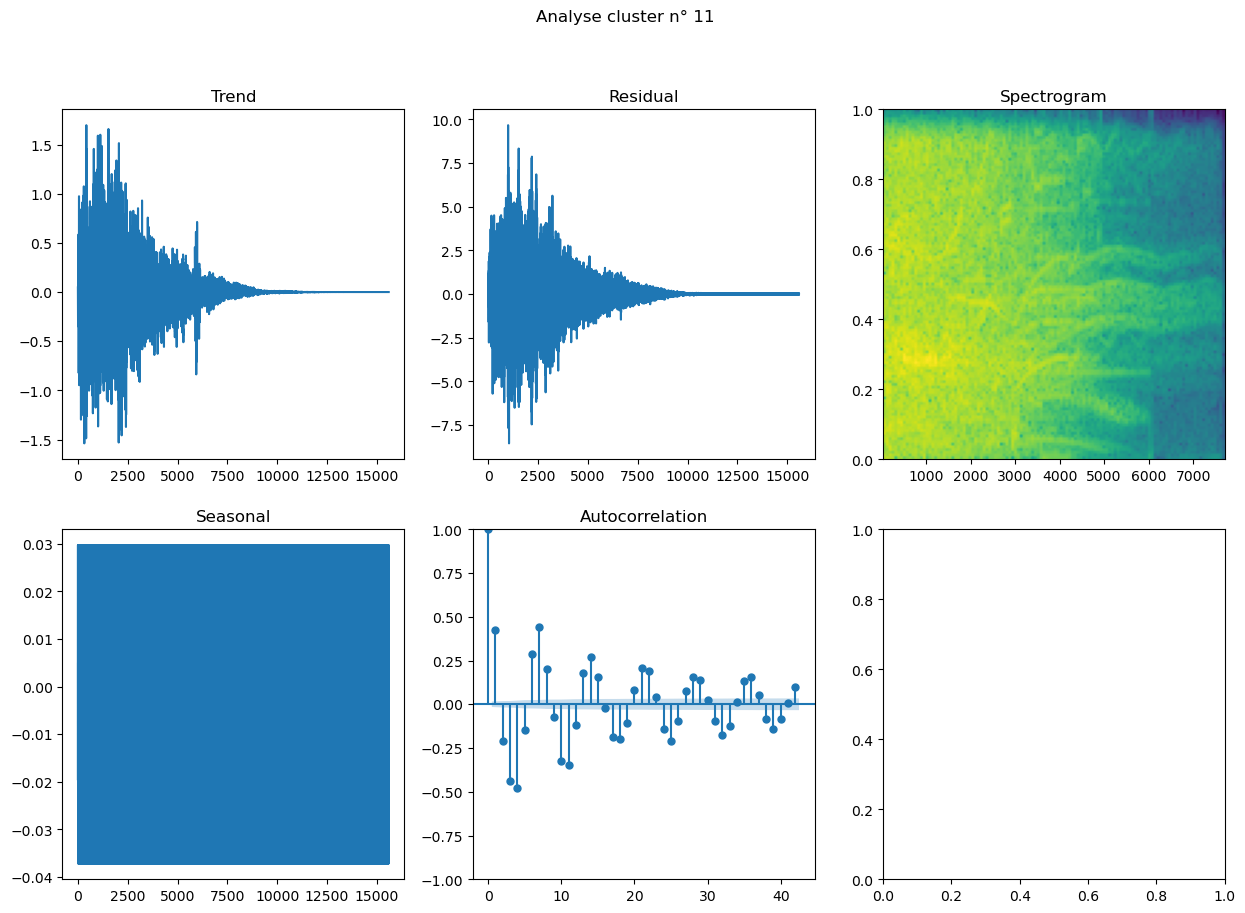

 17%|█████████████▊                                                                     | 3/18 [00:01<00:09,  1.56it/s]

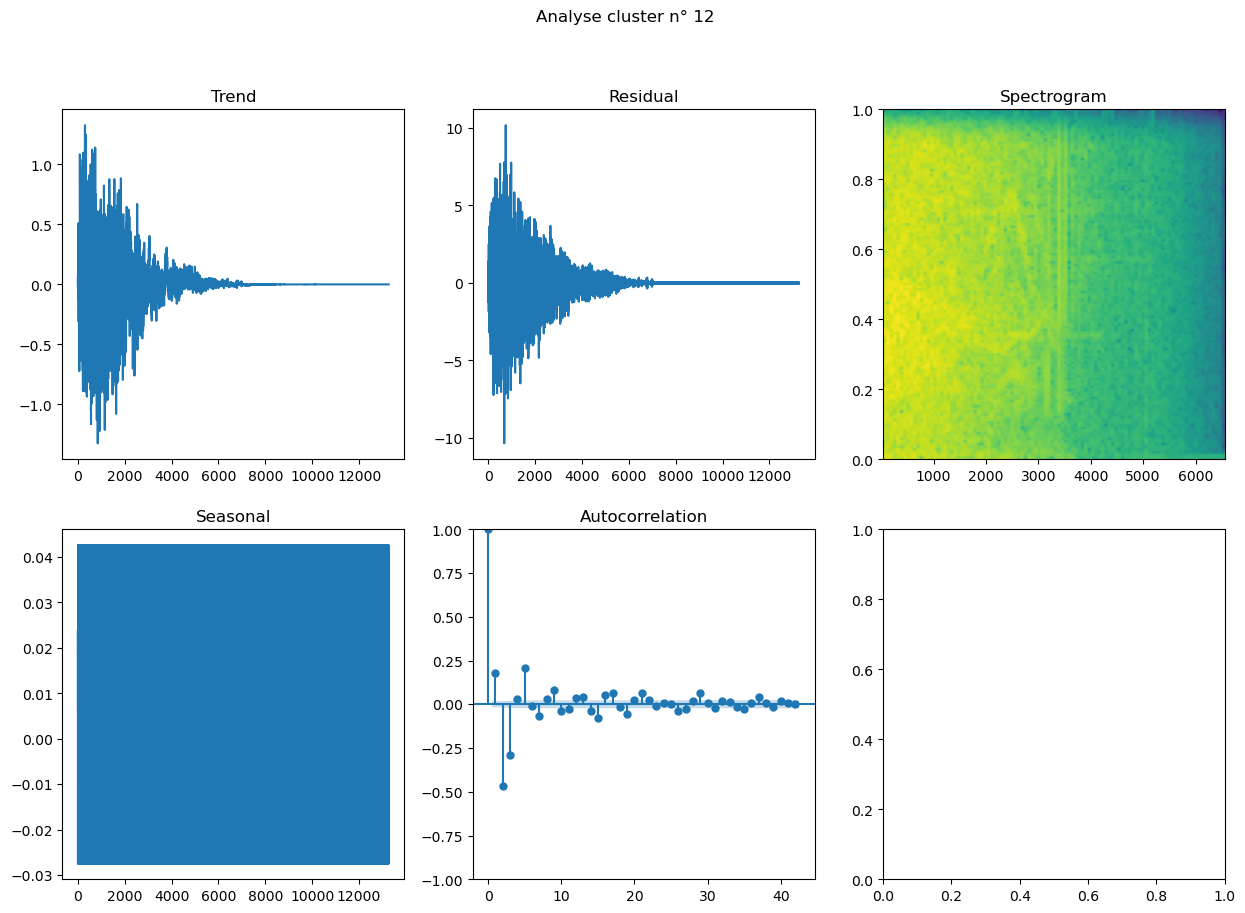

 22%|██████████████████▍                                                                | 4/18 [00:02<00:08,  1.64it/s]

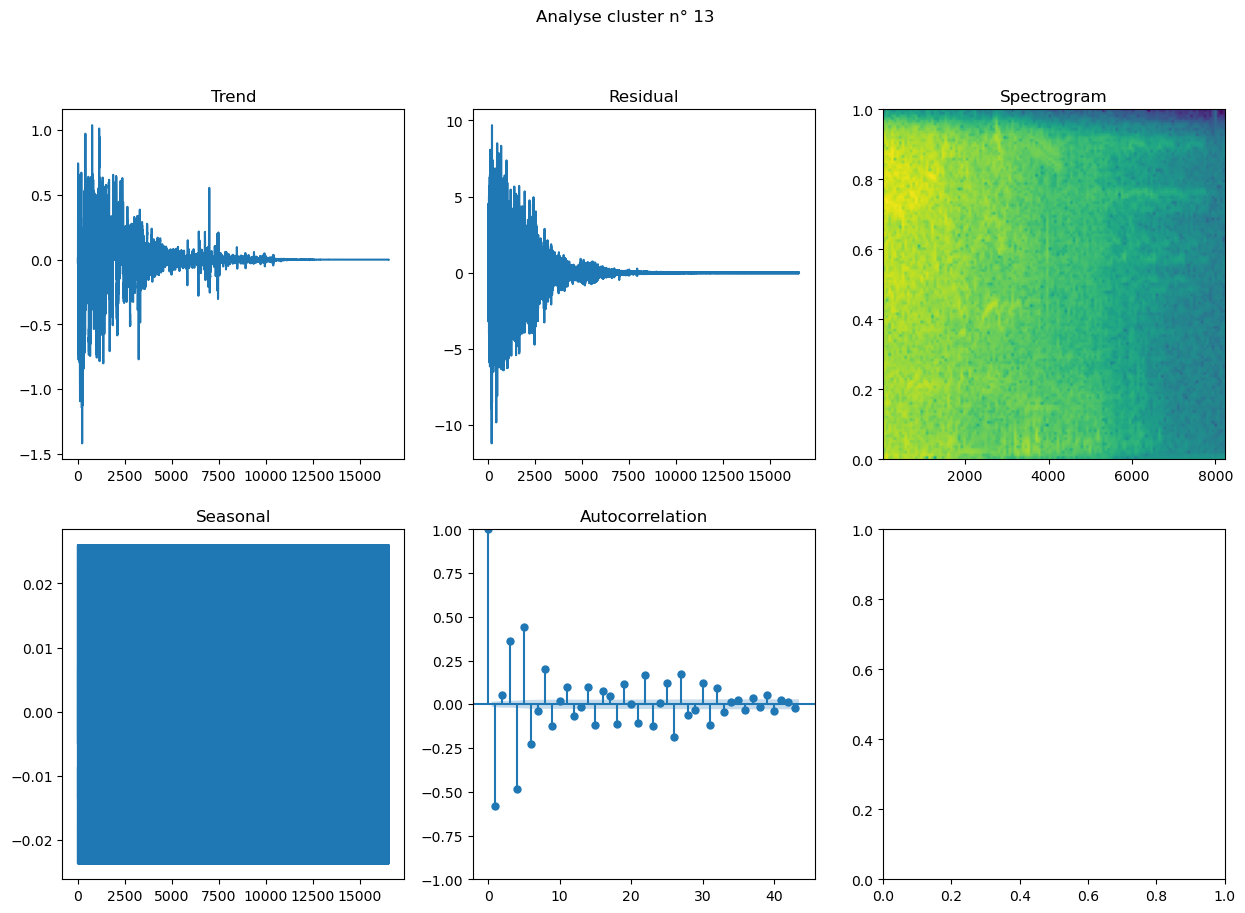

 28%|███████████████████████                                                            | 5/18 [00:03<00:08,  1.62it/s]

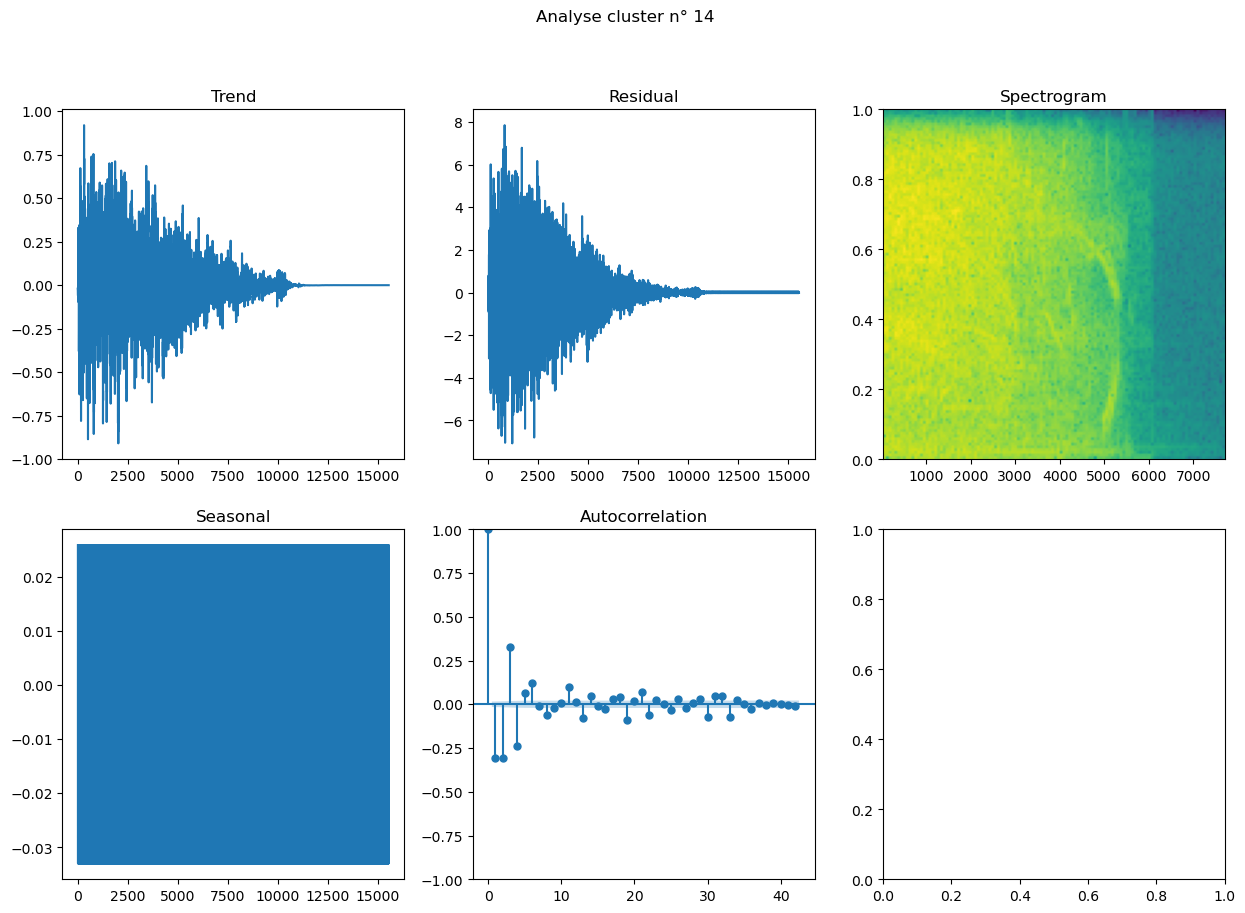

 33%|███████████████████████████▋                                                       | 6/18 [00:03<00:07,  1.58it/s]

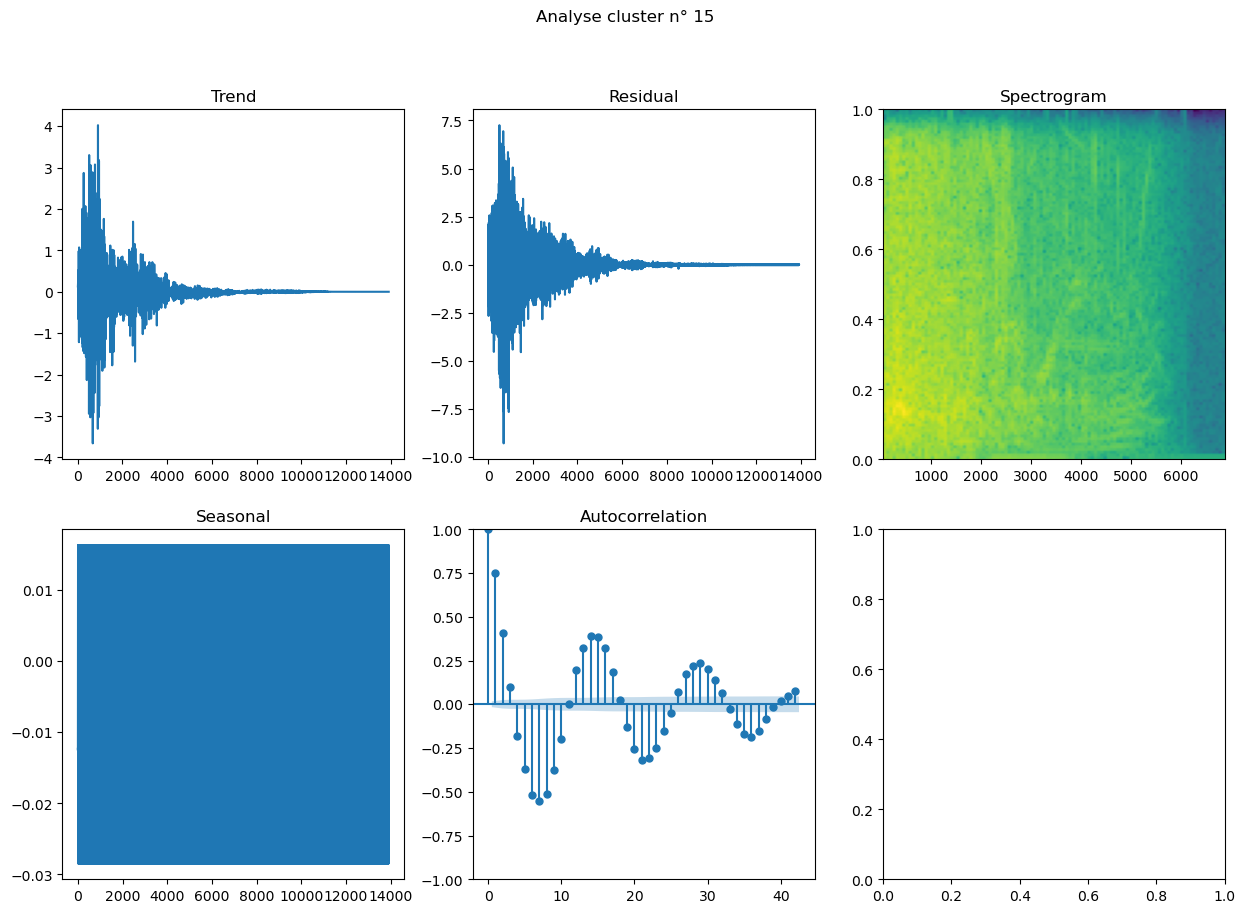

 39%|████████████████████████████████▎                                                  | 7/18 [00:04<00:06,  1.60it/s]

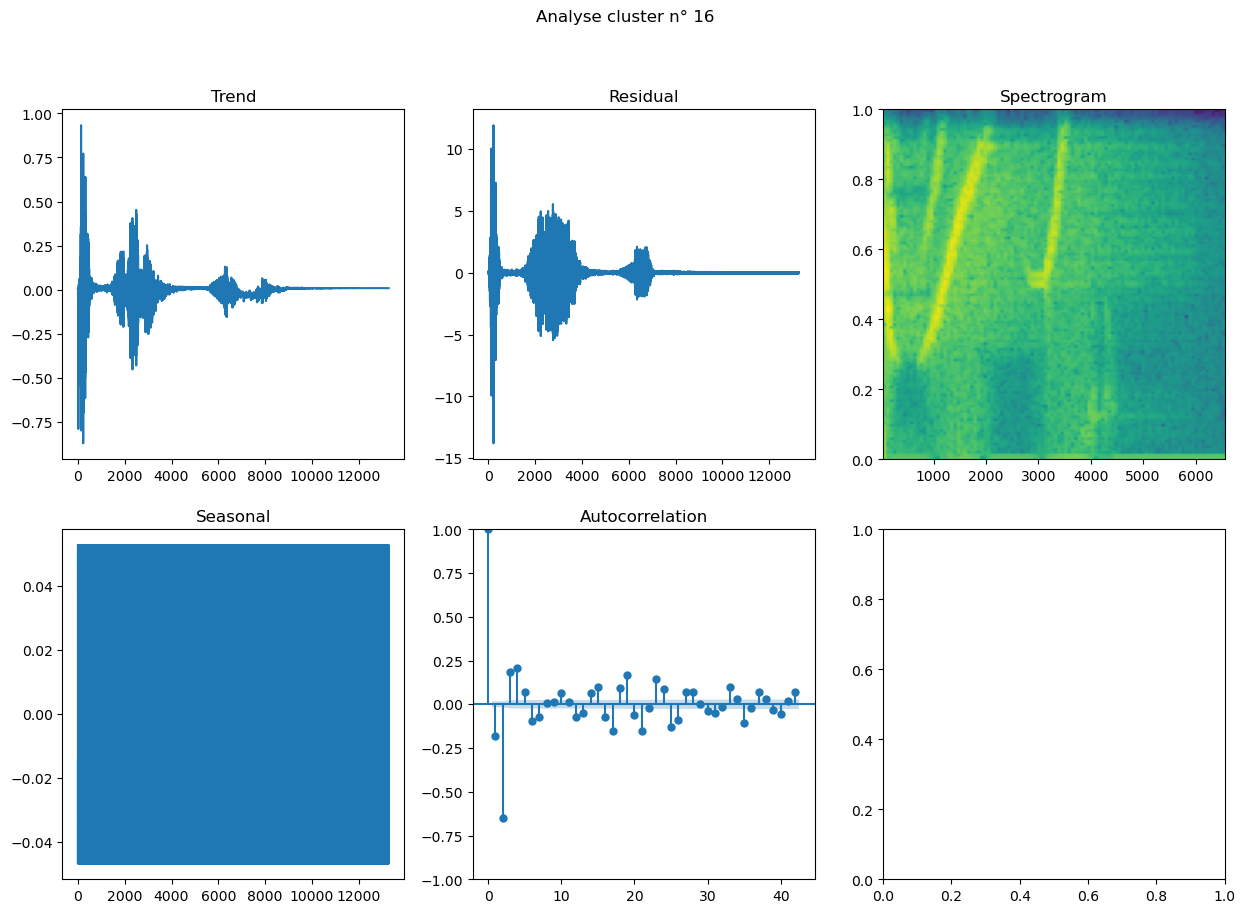

 44%|████████████████████████████████████▉                                              | 8/18 [00:05<00:06,  1.49it/s]

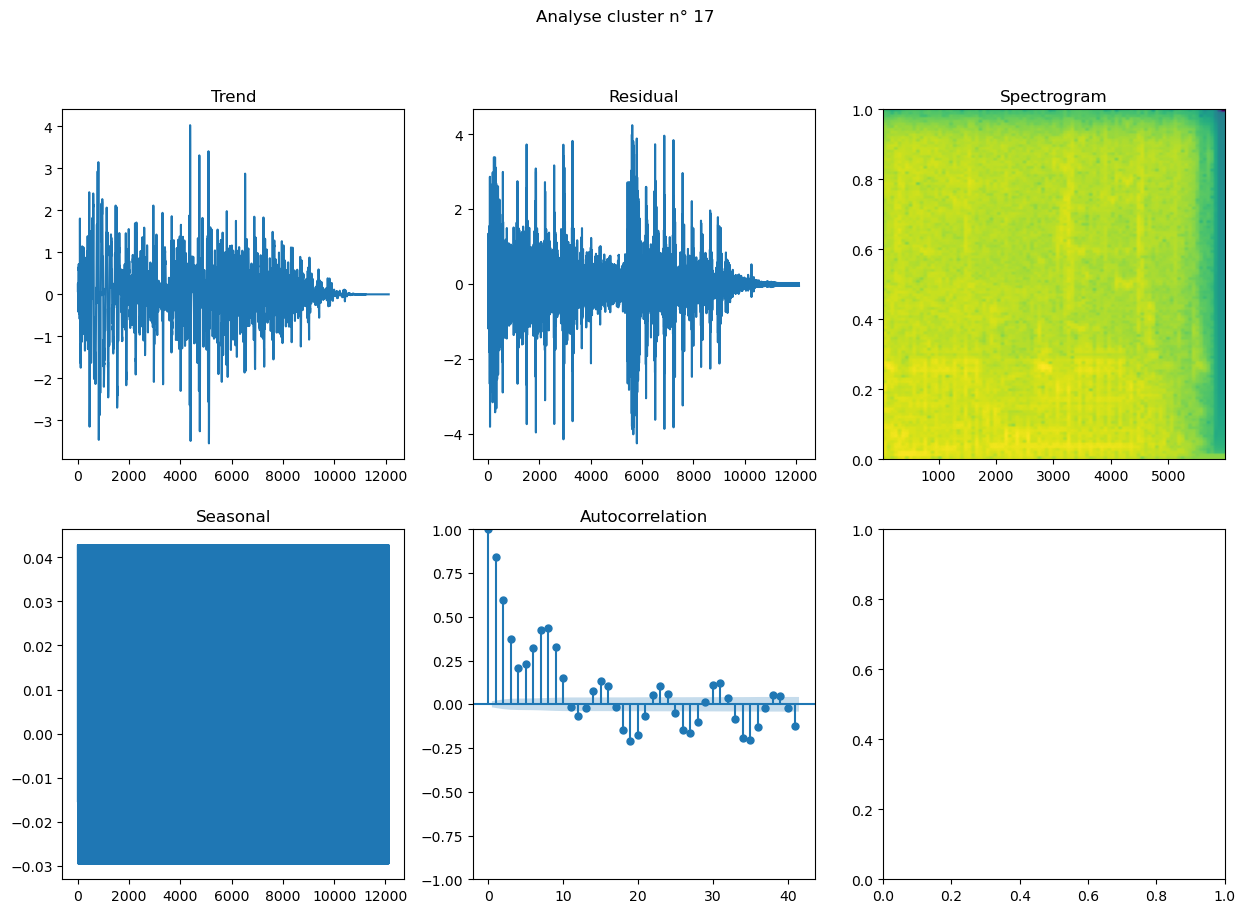

 50%|█████████████████████████████████████████▌                                         | 9/18 [00:06<00:07,  1.18it/s]

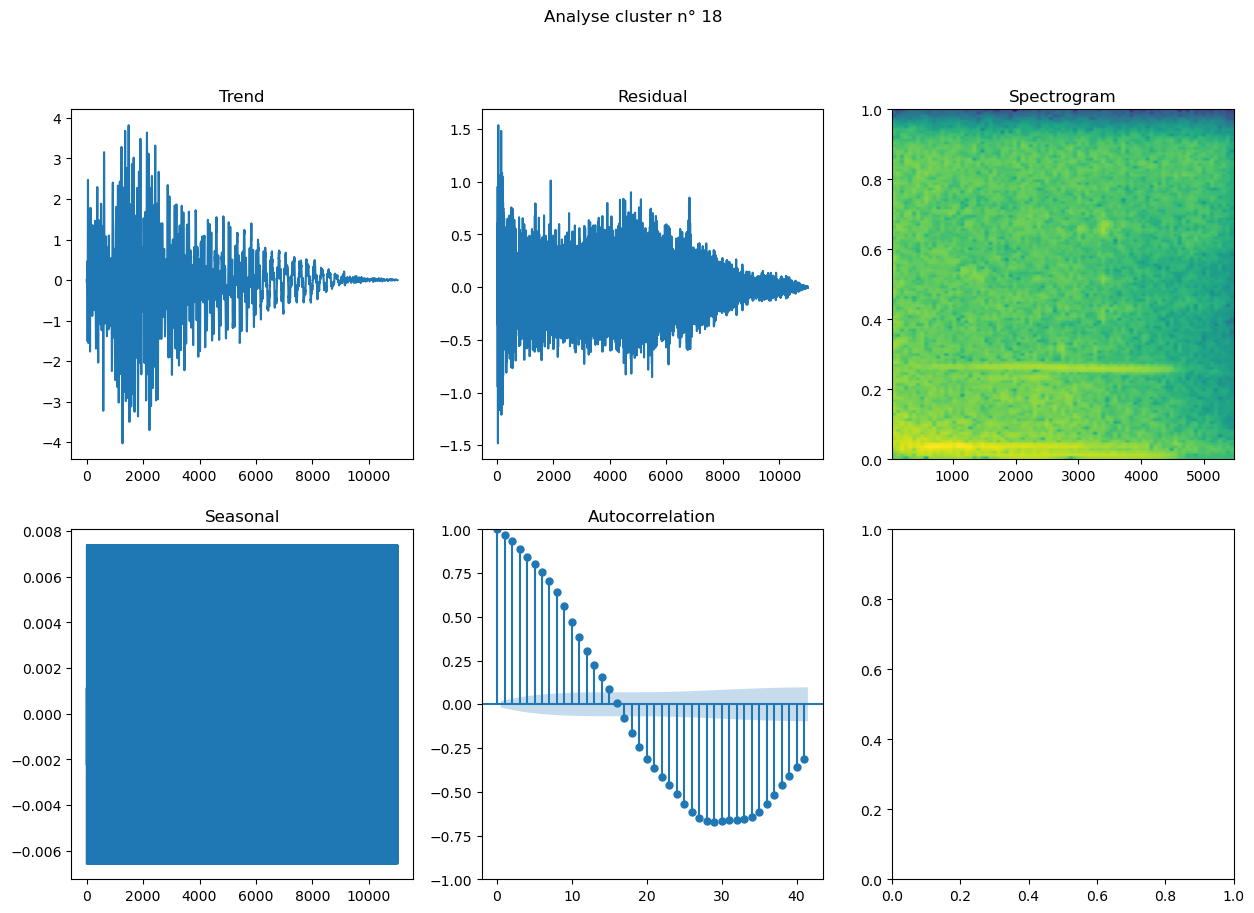

 56%|█████████████████████████████████████████████▌                                    | 10/18 [00:07<00:06,  1.17it/s]

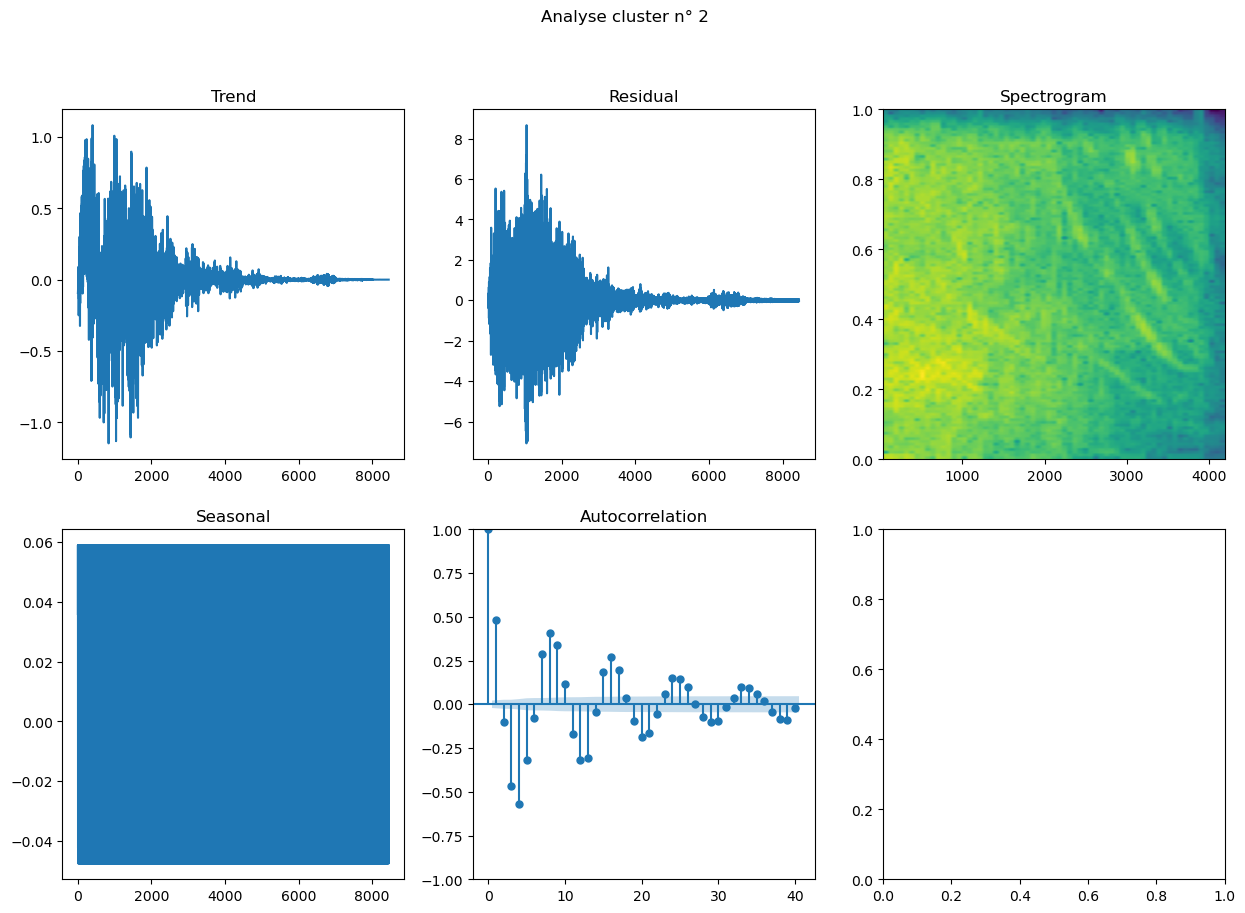

 61%|██████████████████████████████████████████████████                                | 11/18 [00:08<00:05,  1.21it/s]

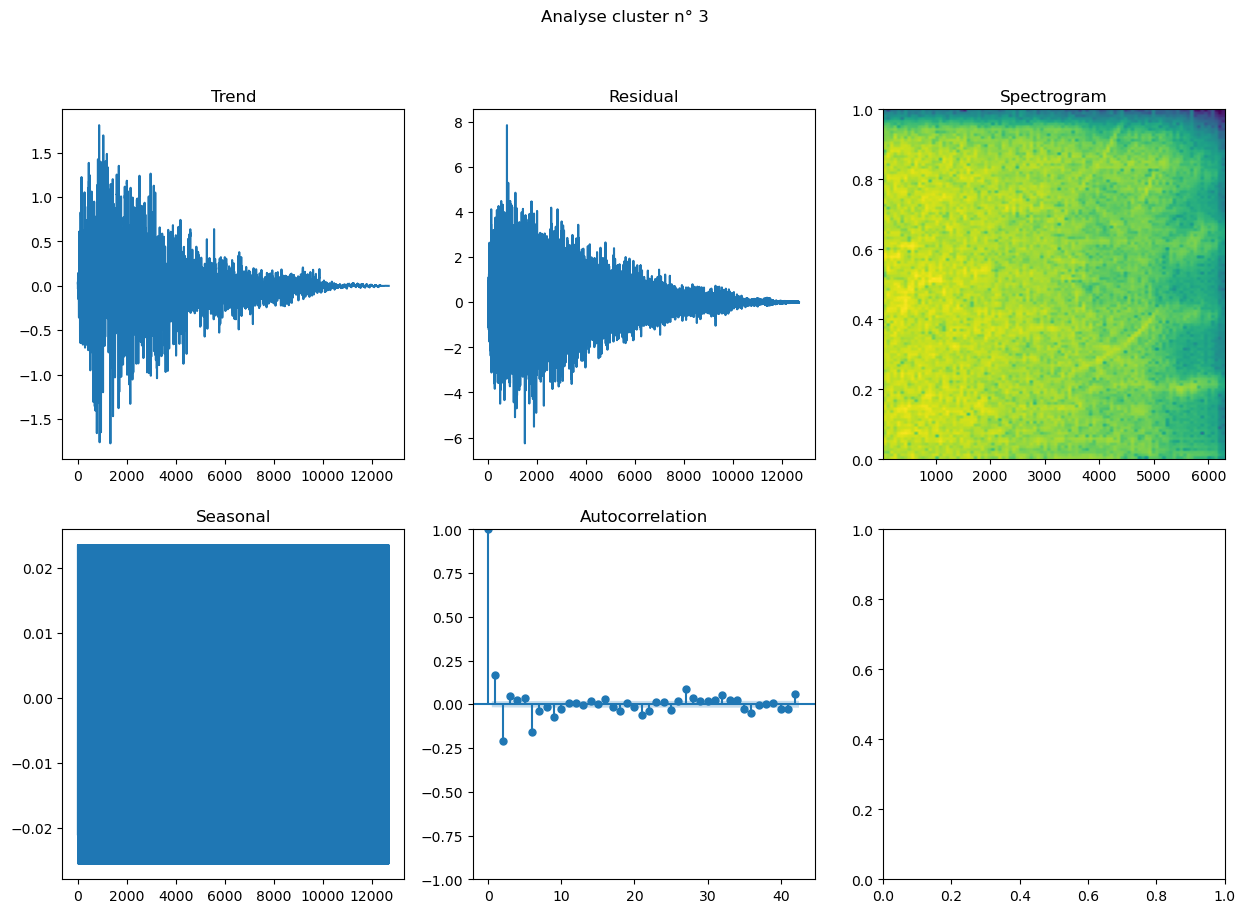

 67%|██████████████████████████████████████████████████████▋                           | 12/18 [00:08<00:04,  1.23it/s]

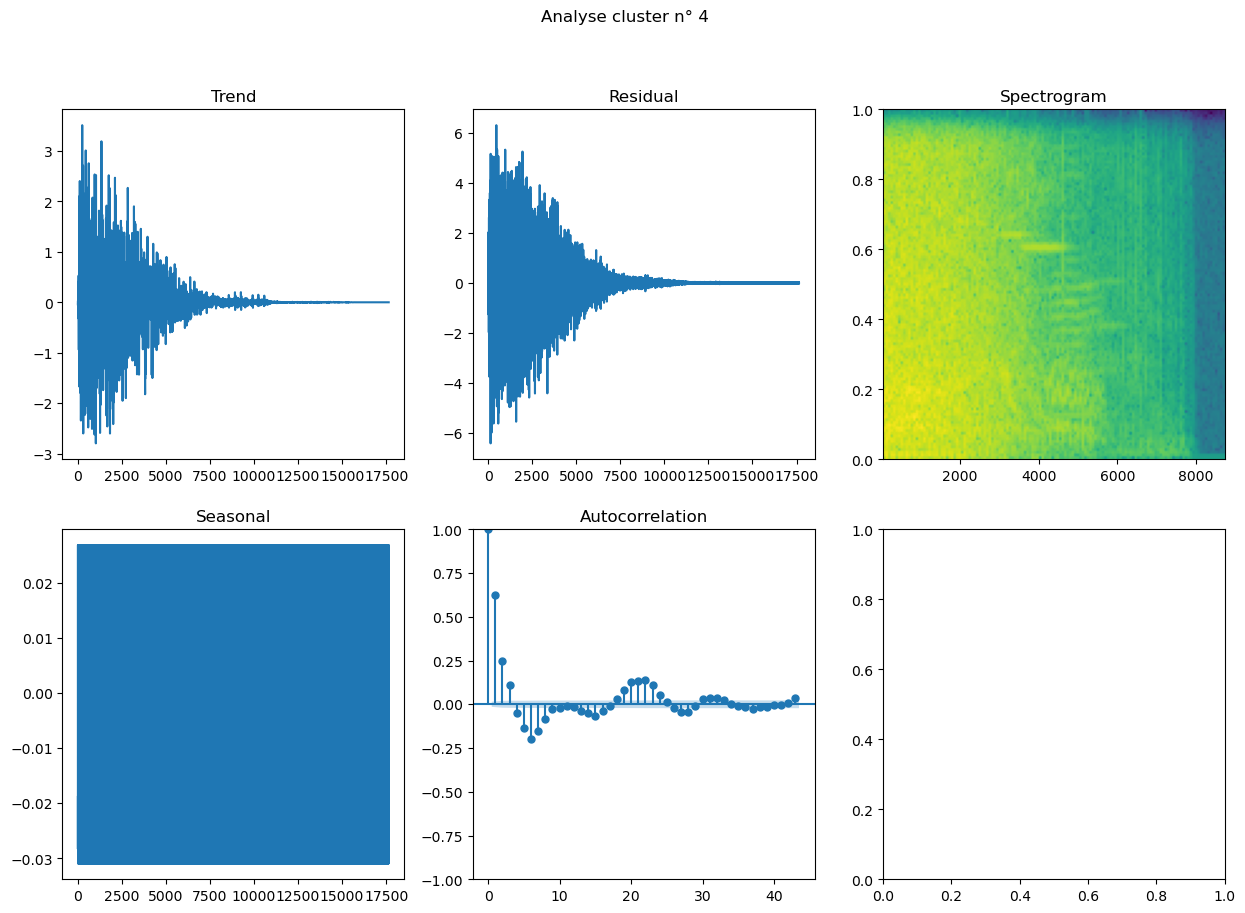

 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [00:09<00:03,  1.27it/s]

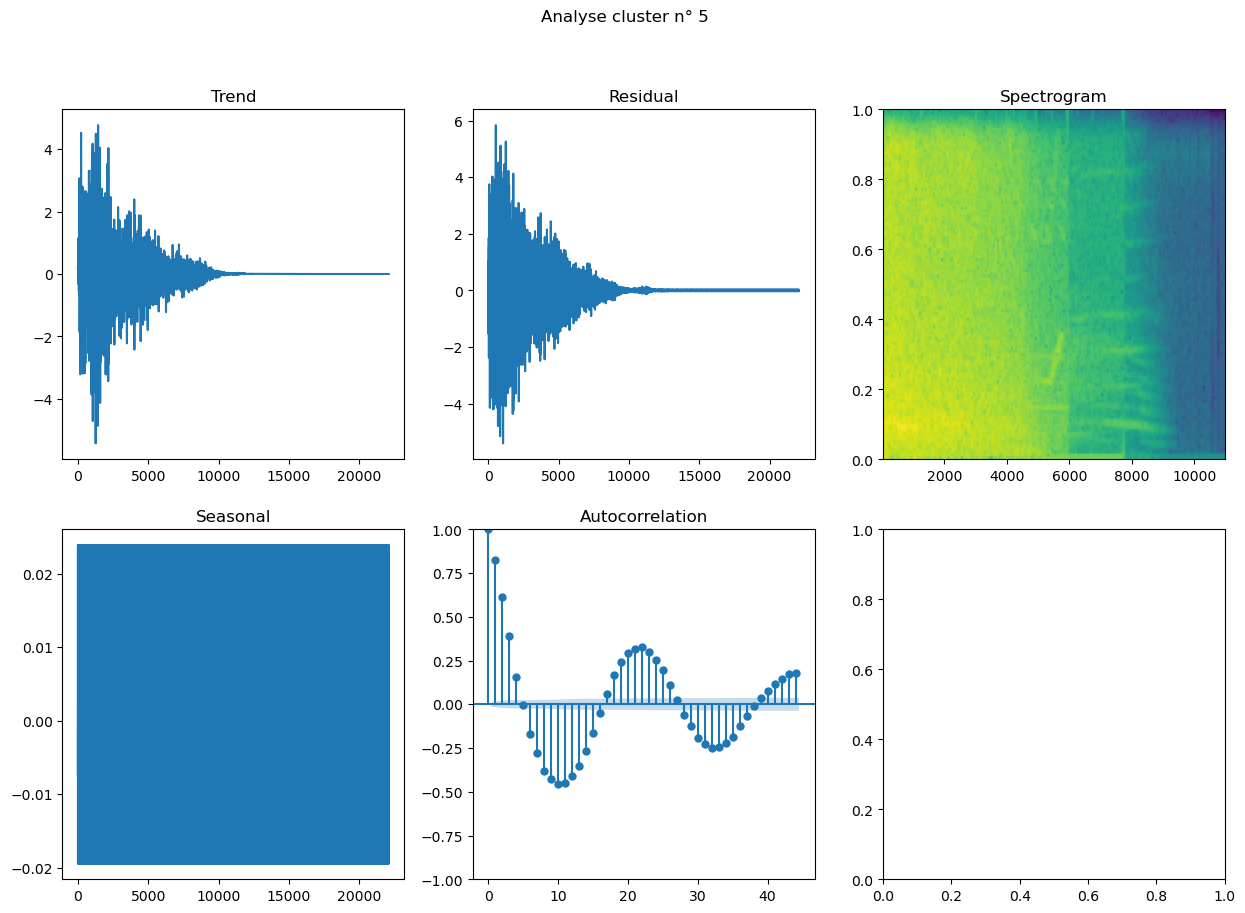

 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:10<00:02,  1.34it/s]

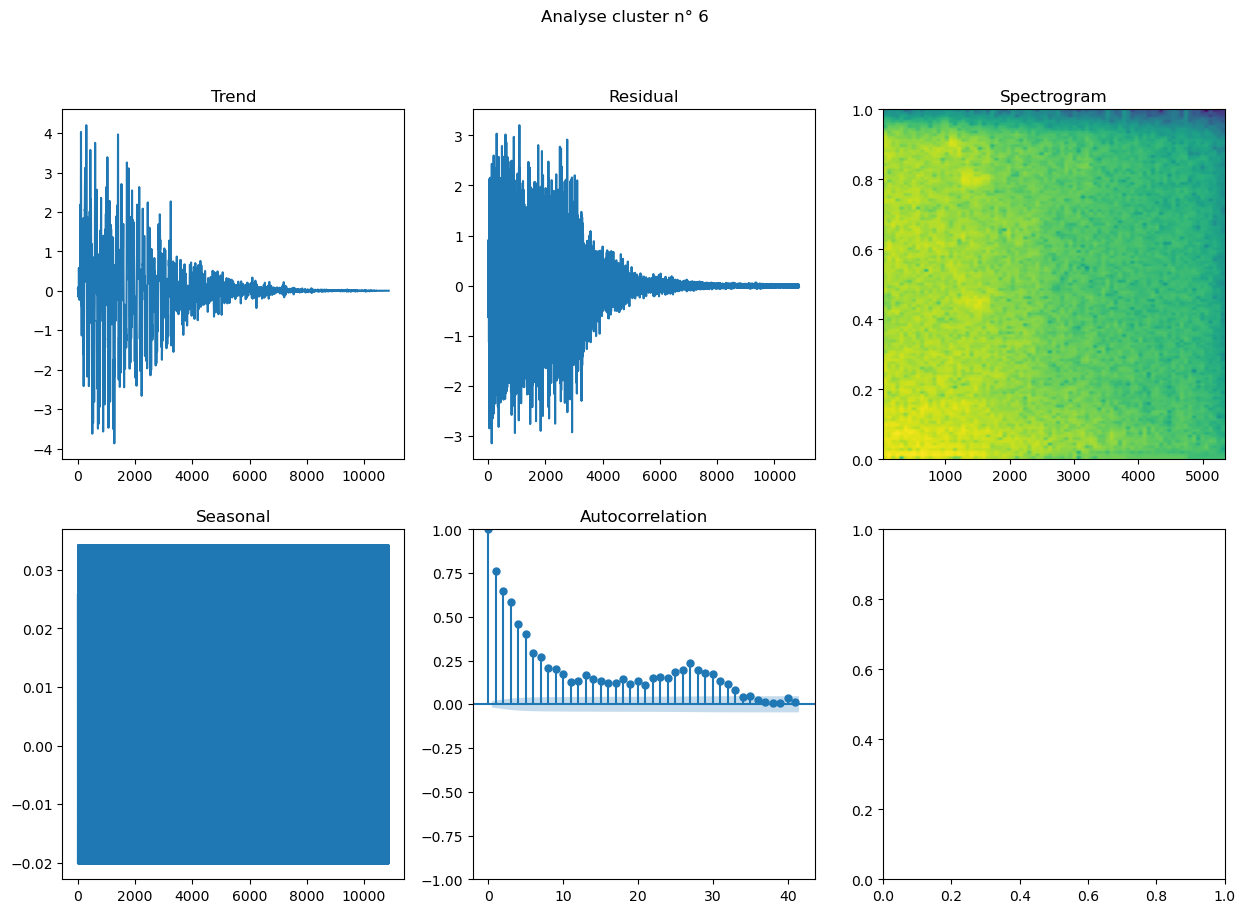

 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:10<00:02,  1.44it/s]

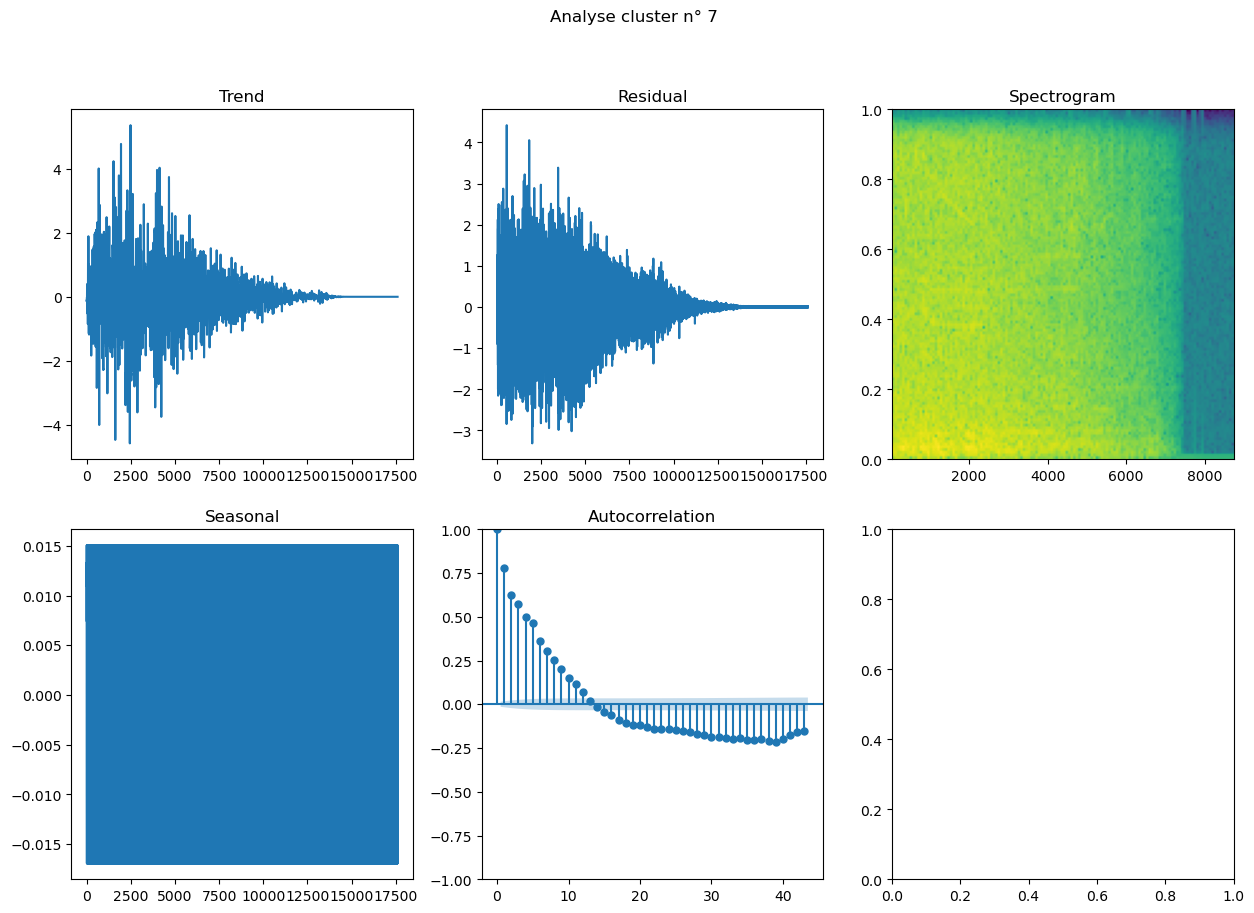

 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [00:11<00:01,  1.34it/s]

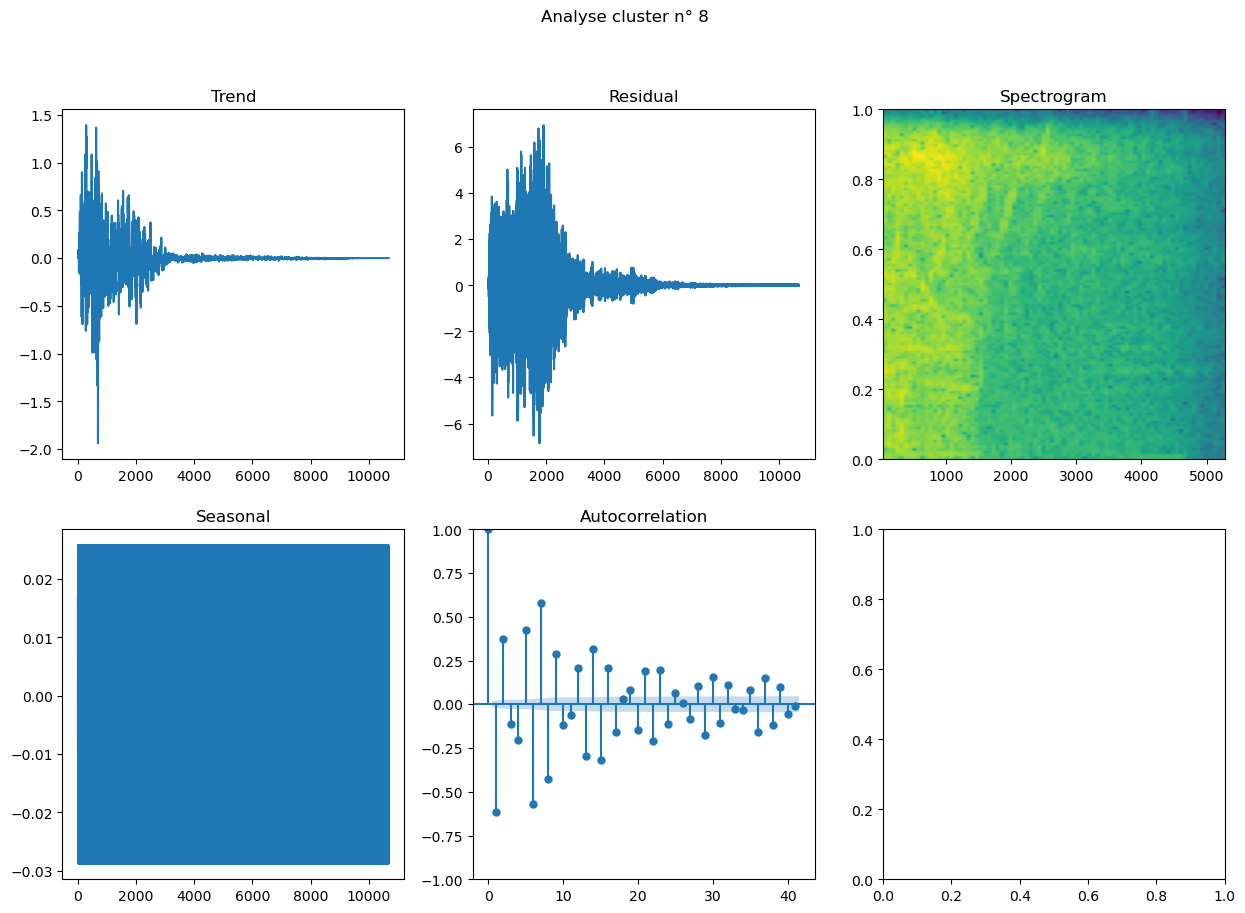

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [00:12<00:00,  1.44it/s]

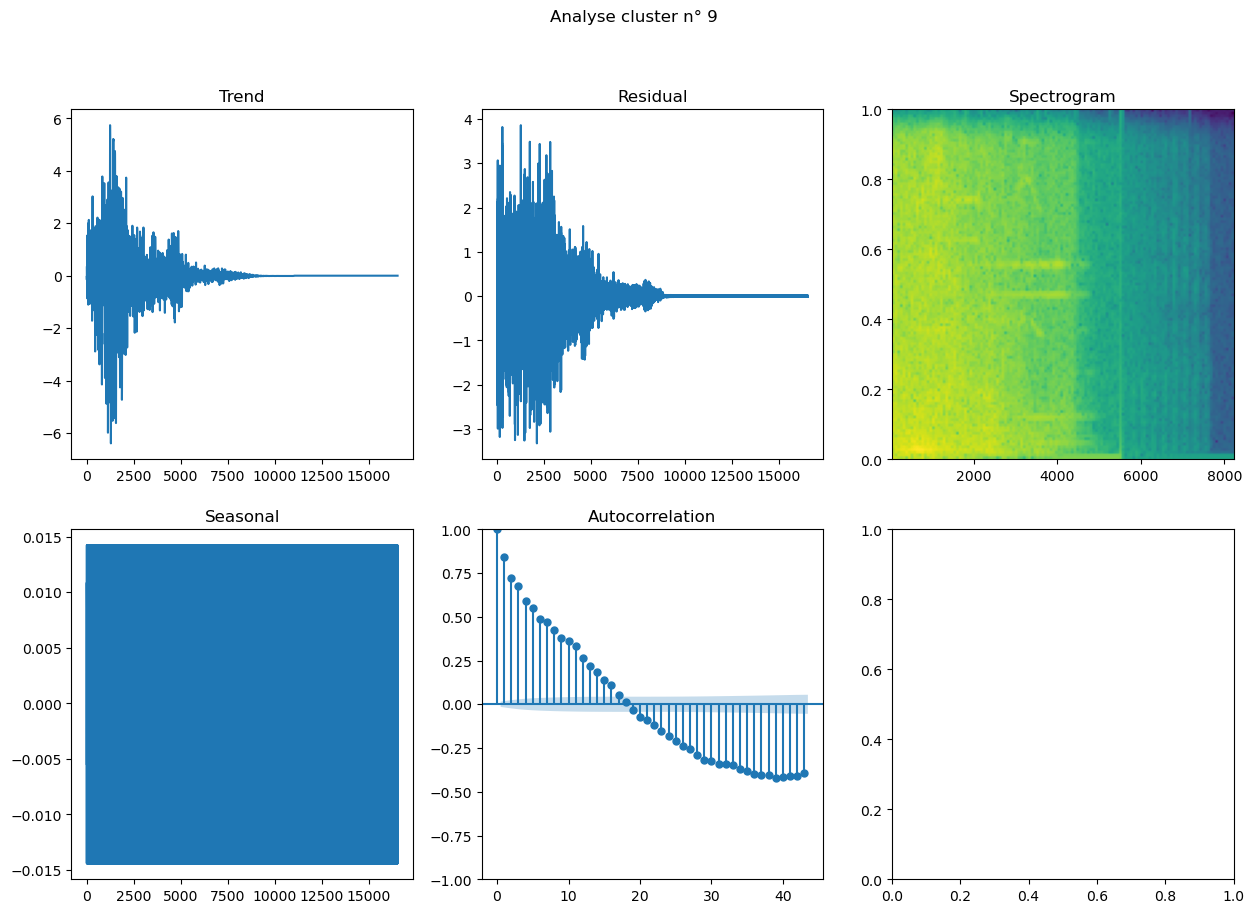

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.40it/s]


In [40]:
for key,centroid in tqdm(Centroids.items()): 
    fig,axs = plt.subplots(2,3,figsize=(15,10))
    decomp = sm.tsa.seasonal_decompose(np.array(centroid),period=10)        
    axs[0,0].plot(decomp.trend)
    axs[0,0].title.set_text("Trend")
    axs[0,1].plot(decomp.resid)
    axs[0,1].title.set_text("Residual")
    centroid = [elem[0] for elem in centroid]
    axs[0,2].specgram(centroid)
    axs[0,2].title.set_text("Spectrogram")
    axs[1,0].plot(decomp.seasonal)
    axs[1,0].title.set_text("Seasonal")

    sm.graphics.tsa.plot_acf(np.array(centroid),ax=axs[1,1])
    fig.suptitle(f"Analyse cluster n° {key}")
    plt.show()